In [86]:
from pylab import *
import numpy as np
import matplotlib, pylab
from dcll.npamlib import plotLIF
from dcll.pytorch_libdcll import *
from dcll.load_dvsgestures_sparse import *

matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['savefig.dpi']=400.
matplotlib.rcParams['font.size']=14.0
matplotlib.rcParams['figure.figsize']=(5.0,3.5)
matplotlib.rcParams['axes.formatter.limits']=[-10,10]
matplotlib.rcParams['axes.labelsize']= 14.
matplotlib.rcParams['figure.subplot.bottom'] = .2
matplotlib.rcParams['figure.subplot.left'] = .2       

In [100]:
Nlayers = 4
directory = "Results/063__20-09-2018/"
#directory = "Results/073__27-09-2018/"
args = np.load(directory+"args.pkl")
testepochs = np.arange(0,args.epochs,args.testinterval, dtype='int')
n_iter_test = 1500
iter_test = np.arange(1,n_iter_test+20,20)
Ntests = len(testepochs)
acc_test = np.load(directory+"acc_test.npy")[:Ntests]

N = 288

bs = [args.batchsize for i in range(N//args.batchsize)] 
if (N%args.batchsize)>0:
    bs.append(N%args.batchsize)

weights = np.array(bs)/N
weighted_acc = np.zeros([Ntests,Nlayers],dtype='float')
for i in range(Nlayers):
    weighted_acc[:,i] = (acc_test[:,:,i]*weights).sum(axis=1)

[0.07291667 0.06944444 0.08680556 0.07291667 0.06944444]
0.07604166666666665


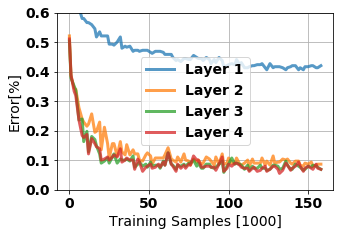

In [101]:
fig = figure()
ax = subplot(111)
for l in range(Nlayers):
    ax.plot(testepochs*args.batchsize//1000, 1-weighted_acc[:,l], linewidth=3, alpha=.75, label = 'Layer {}'.format(l+1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid()
legend()
ax.set_ylabel('Error[%]')
ax.set_xlabel('Training Samples [1000]')
ax.set_ylim([0,.6])
print((1-weighted_acc[-5:,-1]))
print((1-weighted_acc[-10:,-1]).mean())
tight_layout()
savefig('Results/convergence_dvs_gestures.png', dpi=300, frameon=False)


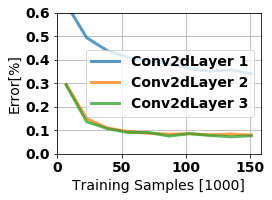

In [90]:
fig = figure(figsize=(4,3))
ax = subplot(111)
for l in range(Nlayers-1):
    x = testepochs*args.batchsize//1000
    y = 1-weighted_acc[:,l]
    ax.plot(x.reshape(-1,10).mean(axis=1), y.reshape(-1,10).mean(axis=1), linewidth=3, alpha=.75, label = 'Conv2dLayer {}'.format(l+1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid()
legend()
ax.set_ylabel('Error[%]')
ax.set_xlabel('Training Samples [1000]')
ax.set_ylim([0,.6])
tight_layout()
savefig('Results/convergence_dvs_gestures_small.png', dpi=300, frameon=False)


In [91]:
voutput = np.load(directory+"doutput4.npy")
soutput = np.load(directory+"doutput1.npy")
soutput = soutput.reshape(soutput.shape[0],  -1)
voutput = voutput.reshape(voutput.shape[0],  -1)
fig = figure(figsize=[10,5])
ax,_ = plotLIF(voutput[:,630:640],soutput[:,630:640],  staggering=1, color='k')
ax.set_ylabel('Neuron')
ax.set_xlabel('Time [ms]')
tight_layout()
fig.savefig('Results/convergence_dvs_gestures_raster.png',dpi = 300)

FileNotFoundError: [Errno 2] No such file or directory: 'Results/073__27-09-2018/doutput4.npy'

In [5]:
from tqdm import tqdm
def accuracy_by_vote(pvoutput, labels):
    from collections import Counter
    pvoutput_ = np.array(pvoutput).T
    n = len(pvoutput_)
    arr = np.empty(n)
    arrl = np.empty(n)
    labels_ = labels.argmax(axis=2).T
    for i in range(n):
        arr[i] = Counter(pvoutput_[i]).most_common(1)[0][0]
        arrl[i] = Counter(labels_[i]).most_common(1)[0][0]
    return float(np.mean((arr == arrl)))

labels = np.load(directory + "testlabels.npy")
inputrate = np.load(directory + "testinputrate.npy")
accs = [[] for i in range(Nlayers)]
for l in range(Nlayers):    
    clout = np.load(directory + "clout{}.npy".format(l+1))
    for i in tqdm(iter_test):
        accs[l].append(accuracy_by_vote(clout[0:i],labels))
        

100%|██████████| 76/76 [00:06<00:00,  8.41it/s]


0.40625
0.09722222222222221
0.08680555555555558
0.07638888888888884


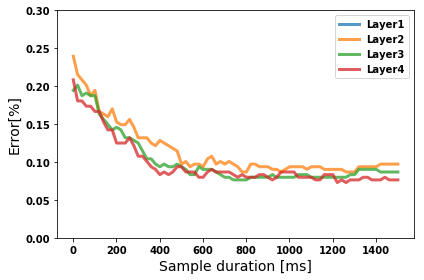

In [10]:
fig = figure()
#ax0 = subplot(211)
ax1 = subplot(111)
#ax0.plot(inputrate[1:], color='k', linewidth=3, alpha=.75)
for l in range(Nlayers):
    ax1.plot(iter_test,1-np.array(accs[l]), linewidth=3, alpha=.75, label = "Layer{}".format(l+1))
    print(1-accs[l][-1])
ax1.set_ylabel('Error[%]')
ax1.set_xlabel('Sample duration [ms]')
ax1.set_ylim([0,.3])
legend()
tight_layout()
savefig('Results/convergence_dvs_gestures_sampleduration.png')

In [7]:
plot_gestures_imshow()

TypeError: plot_gestures_imshow() missing 2 required positional arguments: 'images' and 'labels'

In [58]:
input_test = np.load(directory + "testinput.npy")

In [59]:
def plot_gestures_imshow(images, labels, nim=11, avg=50, do1h = True, transpose=False):
    from matplotlib import colors
    import numpy as np

    np.random.seed(101)
    zvals = np.random.rand(100, 100) * 10

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['red','black', 'black','green'])
    bounds=[-1,-0.1,.1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    import pylab as plt
    plt.figure(figsize = [20,16])
    import matplotlib.gridspec as gridspec
    if not transpose:
        gs = gridspec.GridSpec(images.shape[1]//avg, nim)
    else:
        gs = gridspec.GridSpec(nim, images.shape[1]//avg)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=.0, hspace=.04)
    if do1h:
        categories = labels.argmax(axis=1)
    else:
        categories = labels
    s=[]
    for j in range(nim):
         for i in range(images.shape[1]//avg):
             if not transpose:
                 ax = plt.subplot(gs[i, j])
             else:
                 ax = plt.subplot(gs[j, i])
             on_event = images[j,i*avg:(i*avg+avg),0,:,:].sum(axis=0).T
             off_event = -images[j,i*avg:(i*avg+avg),1,:,:].sum(axis=0).T
             plt.imshow(on_event+off_event, cmap=cmap, norm=norm, interpolation='nearest')
             plt.xticks([])
             if i==0: 
                plt.title(mapping[labels[0,j].argmax()], fontsize=20)
             plt.text(3,5,'t={}ms'.format(i*avg),color='white')
             plt.yticks([])
         s.append(images[j].sum())
    print(s)

[1813.0, 3574.0, 2690.0, 7347.0, 8620.0]


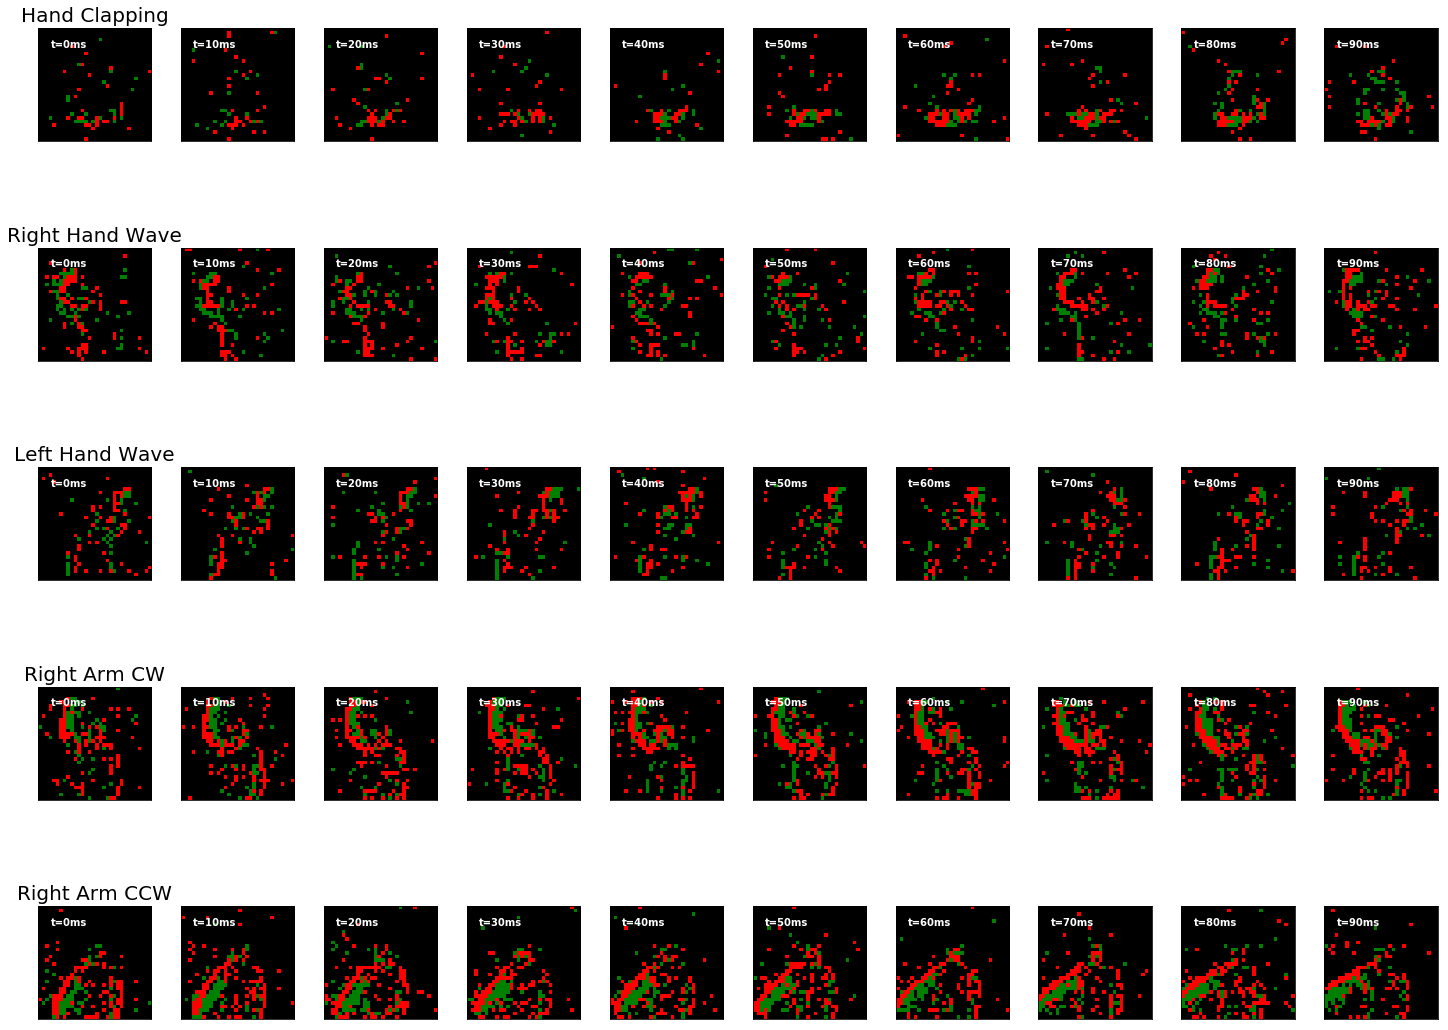

In [60]:
plot_gestures_imshow(input_test[:100].swapaxes(0,1),labels[:5],nim=5, transpose=True, avg=10)
tight_layout()
savefig('Results/convergence_dvs_gestures_sample.png')

In [49]:
input_test.shape

(1800, 1, 2, 32, 32)

In [68]:
y.reshape(-1,4)

array([[0.90972222, 0.70833333, 0.65277778, 0.62847222],
       [0.61458333, 0.57986111, 0.57986111, 0.56597222],
       [0.56597222, 0.55902778, 0.54513889, 0.51736111],
       [0.53472222, 0.52083333, 0.52083333, 0.52083333],
       [0.49305556, 0.49305556, 0.48958333, 0.5       ],
       [0.51736111, 0.47916667, 0.48611111, 0.48263889],
       [0.48611111, 0.46875   , 0.47222222, 0.47222222],
       [0.46875   , 0.47222222, 0.47222222, 0.47222222],
       [0.46527778, 0.46180556, 0.46875   , 0.46875   ],
       [0.46875   , 0.46527778, 0.45833333, 0.45833333],
       [0.45833333, 0.44791667, 0.4375    , 0.44097222],
       [0.43402778, 0.44444444, 0.44444444, 0.44097222],
       [0.44097222, 0.45486111, 0.44791667, 0.44444444],
       [0.44444444, 0.4375    , 0.44791667, 0.44097222],
       [0.42708333, 0.44097222, 0.43055556, 0.44791667],
       [0.4375    , 0.41666667, 0.42013889, 0.42361111],
       [0.42708333, 0.42361111, 0.44097222, 0.42361111],
       [0.43055556, 0.41319444,